FINISH
create HDF5 file: 20160602_tzd_kriging.h5 with w mode
finished writing to 20160602_tzd_kriging.h5


TypeError: Invalid shape (3563100,) for image data

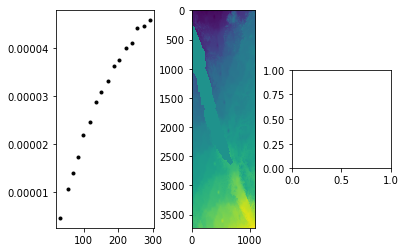

In [2]:
#! /usr/bin/env python
#################################################################
###  This program is part of PyRite  v1.0                     ### 
###  Copy Right (c): 2019, Yunmeng Cao                        ###  
###  Author: Yunmeng Cao                                      ###                                                          
###  Email : ymcmrs@gmail.com                                 ###
###  Univ. : King Abdullah University of Science & Technology ###   
#################################################################

import sys
import os
import re
import subprocess
import argparse
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
import scipy.interpolate as intp
from scipy.optimize import leastsq
from scipy.stats.stats import pearsonr

from pyrite import elevation_models
from pyrite import _utils as ut
from pykrige import OrdinaryKriging

import matlab.engine # using matlab to estimate the variogram parameters
from mintpy.utils import ptime
###############################################################

model_dict = {'linear': elevation_models.linear_elevation_model,
                      'onn': elevation_models.onn_elevation_model,
                      'onn_linear': elevation_models.onn_linear_elevation_model,
                      'exp': elevation_models.exp_elevation_model,
                      'exp_linear': elevation_models.exp_linear_elevation_model}

residual_dict = {'linear': elevation_models.residuals_linear,
                      'onn': elevation_models.residuals_onn,
                      'onn_linear': elevation_models.residuals_onn_linear,
                      'exp': elevation_models.residuals_exp,
                      'exp_linear': elevation_models.residuals_exp_linear}

initial_dict = {'linear': elevation_models.initial_linear,
                      'onn': elevation_models.initial_onn,
                      'onn_linear': elevation_models.initial_onn_linear,
                      'exp': elevation_models.initial_exp,
                      'exp_linear': elevation_models.initial_exp_linear}

para_numb_dict = {'linear': 2,
                  'onn' : 3,
                  'onn_linear':4,
                  'exp':2,
                  'exp_linear':3}

def remove_ramp(lat,lon,data):
    # mod = a*x + b*y + c*x*y
    lat = lat/180*np.pi
    lon = lon/180*np.pi  
    lon = lon*np.cos(lat) # to get isometrics coordinates
    
    p0 = [0.0001,0.0001,0.0001,0.0000001]
    plsq = leastsq(residual_trend,p0,args = (lat,lon,data))
    para = plsq[0]
    data_trend = data - func_trend(lat,lon,para)
    corr, _ = pearsonr(data, func_trend(lat,lon,para))
    return data_trend, para, corr

def func_trend(lat,lon,p):
    a0,b0,c0,d0 = p
    
    return a0 + b0*lat + c0*lon +d0*lat*lon

def residual_trend(p,lat,lon,y0):
    a0,b0,c0,d0 = p 
    return y0 - func_trend(lat,lon,p)

def func_trend_model(lat,lon,p):
    lat = lat/180*np.pi
    lon = lon/180*np.pi  
    lon = lon*np.cos(lat) # to get isometrics coordinates
    a0,b0,c0,d0 = p
    
    return a0 + b0*lat + c0*lon +d0*lat*lon

def OK_function(data0):
    OK,lat0,lon0,np = data0
    z0,s0 = OK.execute('points', lon0, lat0,n_closest_points= np,backend='loop')
    return z0,s0

def dist_weight_interp(data0):
    lat0,lon0,z0,lat1,lon1 = data0
    
    lat0 = np.asarray(lat0)
    lon0 = np.asarray(lon0)
    z0 = np.asarray(z0)
    
    if len(z0)==1:
        z0 = z0[0]
    nn = len(lat1)
    data_interp = np.zeros((nn,))
    weight_all = []
    for i in range(nn):
        dist0 = latlon2dis(lat0,lon0,lat1[i],lon1[i])
        weight0 = (1/dist0)**2
        if len(weight0) ==1:
            weight0 = weight0[0]
        weight = weight0/sum(weight0[:])
        data_interp[i] = sum(z0*weight)
        weight_all.append(weight)
    return data_interp,weight_all

def latlon2dis(lat1,lon1,lat2,lon2,R=6371):
    
    lat1 = np.array(lat1)*np.pi/180.0
    lat2 = np.array(lat2)*np.pi/180.0
    dlon = (lon1-lon2)*np.pi/180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    dist =  R*np.arctan2(np.sqrt((c2*np.sin(dlon))**2 + (c1*s2-s1*c2*cd)**2), s1*s2+c1*c2*cd)

    return dist
    

#geo_file = '/Users/caoy0a/Documents/SCRATCH/AqabaT87S1A/geometryRadar.h5'
#date0 = '20160602'
#    
## determine out put file name
#root_path = '/Users/caoy0a/Documents/SCRATCH/AqabaT87S1A'
#pyrite_dir = root_path + '/pyrite'
#era5_dir = pyrite_dir + '/ERA5'
#era5_raw_dir = era5_dir  + '/raw'
#era5_sar_dir =  era5_dir  + '/sar'
#    
#    
## Get raw values from ERA5
#cdic = ut.initconst()
#fname0 = glob.glob(era5_raw_dir + '/ERA*' + date0 + '*')[0]
#lvls,latlist,lonlist,gph,tmp,vpr = ut.get_ecmwf('ERA5',fname0,cdic, humidity='Q')
#mean_lon = np.mean(lonlist.flatten())
#if mean_lon > 180:    
#    lonlist = lonlist - 360.0 # change to insar format lon [-180, 180]
#    lonlist = np.asarray(lonlist)
#    
#lon = lonlist.flatten() 
#lat = latlist.flatten() 
#    
#lonStep = lonlist[0,1] - lonlist[0,0]
#latStep = latlist[1,0] - latlist[0,0]
#    
#maxlon = max(lonlist[0,:])
#minlon = min(lonlist[0,:])
#    
#maxlat = max(latlist[:,0])
#minlat = min(latlist[:,0])
#        
#Rescale = 10 # default 5  around ~ 6km
#lonStep1 = lonStep/Rescale
#latStep1 = latStep/Rescale
#    
#lonv = np.arange(minlon,maxlon,lonStep1)
#latv = np.arange(maxlat,minlat,latStep1)
#    
#lonvv,latvv = np.meshgrid(lonv,latv)
#    
#    
## Make a height scale
#hgt = np.linspace(cdic['minAltP'], gph.max().round(), cdic['nhgt'])
## Interpolate pressure, temperature and Humidity of hgt
#[Pi,Ti,Vi] = ut.intP2H(lvls, hgt, gph, tmp, vpr, cdic)
## Calculate the delays
#[DDry,DWet] = ut.PTV2del(Pi,Ti,Vi,hgt,cdic)
#    
#hgt0 = hgt.copy()
#idx0 = np.where(((-200<hgt0) & (hgt0 < 3000)))
#hgt00 = hgt0[idx0]
#    
#hgt0 = list(hgt0)
#
#dd0 = DDry.copy()
#dw0 = DWet.copy()
#dt0 = dd0 + dw0
#    
#data0 = dt0
#    
#nk = len(hgt00)
#    
#mdd = np.zeros((nk,),dtype = np.float32)
#mdw = np.zeros((nk,),dtype = np.float32)
#mdt = np.zeros((nk,),dtype = np.float32)
#    
#for i in range(nk):
#    mdd[i] = np.mean(dd0[:,:,hgt0.index(hgt00[i])])
#    mdw[i] = np.mean(dw0[:,:,hgt0.index(hgt00[i])])
#    mdt[i] = np.mean(dt0[:,:,hgt0.index(hgt00[i])])
#    
#    
#R = 6371    
#BIN_NUMB = 50
#max_length = 300
#range0 = max_length/2
#model = 'spherical'
#eng = matlab.engine.start_matlab()
#row,col = lonvv.shape
#Delf_dense = np.zeros((nk,row,col),dtype = np.float32)
#    
#hx = hgt00.copy()
#rescale_h = 10 # default 10  around ~ 15 m/level
#hx_step = hx[1] - hx[0]
#hx_step2 = hx_step/rescale_h
#hgt_dense = np.arange(min(hx),max(hx),hx_step2)
#    
### interp horizontal 
#prog_bar = ptime.progressBar(maxValue=nk)
##for i in range(nk):
#method ='kriging'
#for i in range(nk):
##for i in range(1):
#    k0 = i
#    tzd = data0[:,:,hgt0.index(hgt00[k0])]
#    tzd = tzd.flatten()
#        
#    if method =='kriging':
#        tzd0, para, corr= remove_ramp(lat,lon,tzd)
#        trend = func_trend_model(latvv,lonvv,para)
#        #trend = trend.reshape(row,col)
#        uk = OrdinaryKriging(lon, lat, tzd0, coordinates_type = 'geographic', nlags=BIN_NUMB)
#        Semivariance_trend = 2*(uk.semivariance)    
#        x0 = (uk.lags)/180*np.pi*R
#        y0 = Semivariance_trend
#    
#        LL0 = x0[x0< max_length]
#        SS0 = y0[x0< max_length]
#        sill0 = max(SS0)
#        sill0 = sill0.tolist()
#    
#        LLm = matlab.double(LL0.tolist())
#        SSm = matlab.double(SS0.tolist()) 
#        tt = eng.variogramfit(LLm,SSm,range0,sill0,[],'nugget',0.00001,'model','spherical')
#        variogram_para0 = tt[0]
#    
#        para = variogram_para0[0:3]
#        print(para[1])
#        para[1] = para[1]/R/np.pi*180
#        #print(para)
#        uk.variogram_model_parameters = para
#        z0,s0 = uk.execute('grid', lonv, latv, n_closest_points = 10, backend='loop')
#            #ax.plot(x0,y0,'r.')
#        Delf_dense[i,:,:] = z0 + trend
#    else:
#        # using scipy.interpolate.griddata
#        points = np.zeros((len(lon),2),dtype = np.float32)
#        points[:,0] = lon
#        points[:,1] = lat
#        tzd = tzd.reshape(len(tzd),)
#            
#        grid_tzd = griddata(points, tzd, (lonvv, latvv), method='linear')
#        Delf_dense[i,:,:] = grid_tzd
#        
#    prog_bar.update(i+1, every=1, suffix='{}/{} slices'.format(i+1, nk))
#prog_bar.close()
#    
### interp latitude
#nk2 = len(hgt_dense)
#Delf_dense2 = np.zeros((nk2,row,col),dtype = np.float32)
#    
#initial_function = initial_dict['onn_linear']
#elevation_function = model_dict['onn_linear']
#residual_function = residual_dict['onn_linear']
#    
#    
### elevation model and remove
#y0 = mdt
#x0 = hgt00
#p0 = initial_function(x0,y0)
#plsq = leastsq(residual_function,p0,args = (x0,y0))
#plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#plsq = leastsq(residual_function,plsq[0],args = (x0,y0))
#turb_dense = Delf_dense.copy()
#for i in range(nk):
#    turb_dense[i,:,:] = Delf_dense[i,:,:] - elevation_function(plsq[0],hgt00[i])
#
#prog_bar = ptime.progressBar(maxValue=row)
#for i in range(row):
#    for j in range(col):
#        hy = turb_dense[:,i,j]
#        #print(hy)
#        tck = intp.interp1d(hx,hy,kind='cubic')
#        temp = tck(hgt_dense)
#        Delf_dense2[:,i,j] = temp
#    prog_bar.update(i+1, every=5, suffix='{}/{} slices'.format(i+1, row))
#prog_bar.close()
##
##turb_dense = Delf_dense.copy()
#
##print(hgt_dense)
#linearint = intp.RegularGridInterpolator((hgt_dense,latv[::-1], lonv), Delf_dense2[:,::-1,:], method='linear', bounds_error=False, fill_value = 0.0)
#k0 = 10
#print(hgt_dense[k0])
#print(hgt_dense[1])
#zz0 = Delf_dense2[k0,::-1,:]
#print(zz0.shape)
#print(zz0)
#print(Delf_dense2[1,::-1,:])
#linearint2 = intp.RegularGridInterpolator((latv[::-1], lonv), zz0, method='linear', bounds_error=False, fill_value = 0.0)
#
#
#eng.quit()
#    
#    ## interp InSAR
#    
#    #geo_file = '/Users/caoy0a/Documents/SCRATCH/LosAngelesT71F479D/geometryRadar.h5'
#datasetNames = ut.get_dataNames(geo_file)
#meta = ut.read_attr(geo_file)
#if 'latitude' in datasetNames: 
#    lats = ut.read_hdf5(geo_file,datasetName='latitude')[0]
#    lons = ut.read_hdf5(geo_file,datasetName='longitude')[0]
#else:
#    lats,lons = ut.get_lat_lon(meta)
#    
#heis = ut.read_hdf5(geo_file,datasetName='height')[0]
#val_turb = np.zeros((heis.shape),dtype = np.float32)   
#val_turb0 = val_turb.flatten()
#  
#    
#z_turb = np.zeros((heis.shape),dtype = np.float32)   
#z_turb0 = val_turb.flatten()    
#    
#    
#heis0 = heis.flatten()
#lats0 = lats.flatten()
#lons0 = lons.flatten()
#    
#hh = heis0[~np.isnan(lats0)]
#lala = lats0[~np.isnan(lats0)]
#lolo = lons0[~np.isnan(lats0)]
#    

    
val_turb22 = linearint2(np.vstack((lala, lolo)).T)
val_turb2 = val_turb0.copy()
val_turb2[~np.isnan(lats0)]= val_turb22

val_turb00 = linearint(np.vstack((hh, lala, lolo)).T)
val_turb0[~np.isnan(lats0)] = val_turb00

row0,col0 = lats.shape

val_turb2 = val_turb2.reshape(row0,col0)
val_turb = val_turb0.reshape(row0,col0)
val_topo = elevation_function(plsq[0],heis)
    
val_total = val_turb + val_topo
    
#####
meta['UNIT'] = 'm'
meta['FILE_TYPE'] = 'delay'
    
datasetDict = dict()
datasetDict['turb_sar'] = z_turb0
datasetDict['hgt_sar'] = val_topo
datasetDict['aps_sar'] = val_total

OUT = '20160602_tzd_kriging.h5'
ut.write_h5(datasetDict, OUT, metadata=meta, ref_file=None, compression=None)

    



#print(tt)
#print(plsq)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.plot(LL0,SS0,'k.')


ax = fig.add_subplot(132)
plt.imshow(val_turb)

ax = fig.add_subplot(133)
plt.imshow(z0)
plt.show()
